In [6]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [7]:
inicio = dt.date(2013, 1, 2)
final = dt.date(2022, 12, 30)

In [8]:
lista_acoes = ['MGLU3.SA', 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'ELET3.SA', 'LREN3.SA', 'ABEV3.SA', 'BBAS3.SA', 'SUZB3.SA', 'BBDC4.SA']
precos = pd.DataFrame()       
for i in acoes:
    precos[i] = yf.download(i, period='11y')['Adj Close']

precos = precos.drop(index = precos[precos.index.year >= 2023].index)
precos = precos.drop(index = precos[precos.index.year <= 2012].index)

precos

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MGLU3.SA,PETR4.SA,VALE3.SA,ITUB4.SA,ELET3.SA,LREN3.SA,ABEV3.SA,BBAS3.SA,SUZB3.SA,BBDC4.SA
Date,,,,,,,,,,
2013-01-02,0.362282,7.108663,24.720068,10.152313,3.863270,10.831508,11.399804,13.326800,17.512335,8.017256
2013-01-03,0.377225,7.364993,24.299654,10.455585,4.006779,10.851727,11.601920,13.590240,17.512335,8.495897
2013-01-04,0.374970,7.375827,23.924091,10.393753,4.052702,10.838243,11.410655,13.424944,17.512335,8.353257
2013-01-07,0.366229,7.249465,23.453232,10.217086,4.012520,10.653564,11.542235,13.507594,17.512335,8.310909
2013-01-08,0.363692,7.040069,23.268253,10.258307,3.673838,10.596947,11.528668,13.662552,17.512335,8.339882
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,2.680000,22.367809,84.465065,24.818089,42.910503,21.653334,14.620000,34.267910,46.840000,14.451961
2022-12-26,2.660000,22.207531,85.238083,24.325470,42.582642,20.495455,14.520000,34.219345,46.180000,14.108319
2022-12-27,2.520000,22.358906,87.273392,24.187536,41.459953,20.168873,14.520000,33.082912,47.500000,14.041501


In [9]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno Logarítmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

matriz_cov

,MGLU3.SA,PETR4.SA,VALE3.SA,ITUB4.SA,ELET3.SA,LREN3.SA,ABEV3.SA,BBAS3.SA,SUZB3.SA,BBDC4.SA
MGLU3.SA,0.001596,0.000364,0.000254,0.000243,0.000396,0.000390,0.000165,0.000376,0.000062,0.000291
PETR4.SA,0.000364,0.001010,0.000403,0.000373,0.000501,0.000321,0.000191,0.000553,0.000063,0.000432
VALE3.SA,0.000254,0.000403,0.000785,0.000194,0.000248,0.000152,0.000108,0.000258,0.000093,0.000231
ITUB4.SA,0.000243,0.000373,0.000194,0.000424,0.000340,0.000260,0.000162,0.000417,0.000016,0.000398
ELET3.SA,0.000396,0.000501,0.000248,0.000340,0.001163,0.000349,0.000184,0.000494,0.000012,0.000383
LREN3.SA,0.000390,0.000321,0.000152,0.000260,0.000349,0.000563,0.000171,0.000338,0.000015,0.000297
ABEV3.SA,0.000165,0.000191,0.000108,0.000162,0.000184,0.000171,0.000287,0.000183,0.000034,0.000178
BBAS3.SA,0.000376,0.000553,0.000258,0.000417,0.000494,0.000338,0.000183,0.000747,0.000008,0.000472
SUZB3.SA,0.000062,0.000063,0.000093,0.000016,0.000012,0.000015,0.000034,0.000008,0.000369,0.000021
BBDC4.SA,0.000291,0.000432,0.000231,0.000398,0.000383,0.000297,0.000178,0.000472,0.000021,0.000512


In [10]:
numero_carteiras = 100000
df_retornos_esperados= np.zeros(numero_carteiras)
df_volatilidades_esperadas = np.zeros(numero_carteiras)
df_sharpe = np.zeros(numero_carteiras)
df_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos / np.sum(pesos)
    df_pesos[k, :] = pesos
    
    df_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    df_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    df_sharpe[k] = df_retornos_esperados[k] / df_volatilidades_esperadas[k]

In [11]:
indice_sharpe_maximo = df_sharpe.argmax()
df_pesos[indice_sharpe_maximo]

array([0.12078656, 0.04319766, 0.06732994, 0.01290002, 0.31196311,
       0.0488786 , 0.0634904 , 0.04687784, 0.27337734, 0.01119853])

In [12]:
df_retornos_esperados_arit = np.exp(df_retornos_esperados) - 1
df_retornos_esperados_arit

array([0.11549231, 0.11880127, 0.13335596, ..., 0.12810032, 0.11406217,
       0.10985247])

In [13]:
eixoY_fronteira_eficiente = np.linspace(df_retornos_esperados_arit.min(),
                                        df_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno

def chacando_soma_pesos(peso_teste):
    
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = df_volatilidades_esperadas[k] = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([0, 1] for ativo in lista_acoes)

eixoX_fronteira_eficiente = []

for retorno_possivel in eixoY_fronteira_eficiente:
    # Vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':chacando_soma_pesos},
                 {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites,
                     constraints=restricoes)
    eixoX_fronteira_eficiente.append(result['fun'])

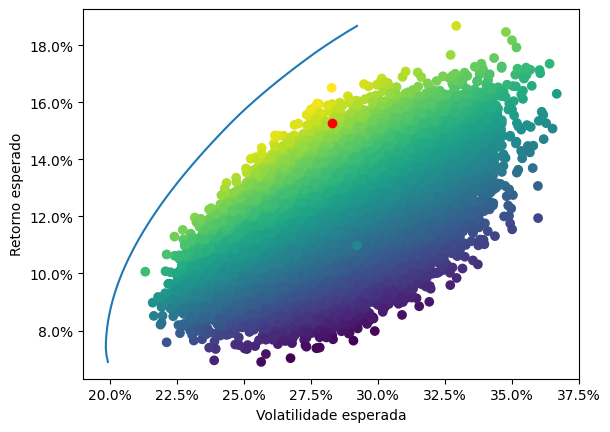

In [14]:
fig, ax = plt.subplots()

ax.scatter(df_volatilidades_esperadas, df_retornos_esperados_arit, c= df_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
ax.scatter(df_volatilidades_esperadas[indice_sharpe_maximo],
          df_retornos_esperados[indice_sharpe_maximo], c = 'red')
ax.plot(eixoX_fronteira_eficiente, eixoY_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='x', colors='white')

plt.show()